# Math 3910: Optimal Estimation and Control  |  Luenberger Example

## Problem/Assignment Overview

In this code, we consider building a Luenberger Observer for the "train car on a track" problem.  Here, we consider a train car that is modeled by 
$$\dot{\vec{x}} = \underbrace{\begin{bmatrix} 0& 1\\0 & 0\end{bmatrix}}_{A}\vec{x} + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{B}u, \qquad \vec{x}(t_0) = \vec{x}_0$$
$$\vec{y} = \underbrace{\begin{bmatrix}1&0\end{bmatrix}}_{C}\vec{x}$$

In the above, the only thing that we can estimate or observe is the position.  We would like to be able to estimate the full state which includes the velocity. In order to estimate these, we consider the following estimate equation given by 
$$\dot{\hat{\vec{x}}} = F\hat{\vec{x}} + G\vec{u} + H\vec{y}.$$
If we define the error to be $\vec{e} = \vec{x} - \hat{\vec{x}}$, then the evolution of $\vec{e}$ is given by 
\begin{align*}
\dot{\vec{e}} &= \underbrace{A\vec{x} + B\vec{u}}_{\dot{\vec{x}}} - \underbrace{\left(F\hat{\vec{x}} + G\vec{u} + H\vec{y}\right)}_{\dot{\hat{\vec{x}}}}\\\\
&= A\vec{x} + B\vec{u} - F\hat{\vec{x}} - G\vec{u} - HC\vec{x}\\
&= \left(A - HC\right)\vec{x} + \left(B-G\right)\vec{u} - F\hat{\vec{x}} \qquad \longrightarrow\qquad\textsf{ choose $F = A-HC$ and $G = B$}\\
&= \left(A - HC\right)\left(\vec{x}-\hat{\vec{x}}\right)\\
\dot{\vec{e}}&= \left(A - HC\right)\vec{e}
\end{align*}
The matrix $H$ is chosen to force the error between the estimate $\hat{\vec{x}}$ and the true state $\vec{x}$ to go to zero as $t$ increases.  This ensures that regardless of the initial condition $\hat{\vec{x}}(t_0) = \hat{\vec{x}}_0$, the error defined as $\vec{e} = \vec{x} - \hat{\vec{x}}$ satisfies $\vec{e}\to\vec{0}$ as $t \to \infty$.  


In the following block of code, we initialize the libraries needed.  Note, the `control` library is not typically installed by default. If you are using Anaconda, you can include the following command to install the code
```
conda install -c conda-forge control slycot
```


In [2]:
from matplotlib import pyplot as plt 
import numpy as np
import control as ctrl
plt.rcParams['text.usetex'] = True


## The Code for the Unobservable Example

### Preliminaries and Matrix Definitions for the Unobservable Problem

In the section below, we define attempt to estimate the full state $\hat{\vec{x}}$ given the following system and measurement: 
\begin{align*}
\dot{x} &= \underbrace{\begin{bmatrix}0 & 1\\0 & 0\end{bmatrix}}_{A}\vec{x} + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{B}u, \qquad \textsf{where } u(t) = -\sin(t)\\ \\
\vec{y} &= \underbrace{\begin{bmatrix} 0 & 1\end{bmatrix}}_{C}\vec{x}
\end{align*}

In the following block, we define the matrices $A$, $B$, and $C$, as well as the function $u(t) = -\sin(t)$.  

In [20]:
# Define the matrices for the model.  
A = np.array([[0., 1.],[0., 0.]]);
B = np.array([[0.],[1.]]);
C = np.array([[0,1]])

# Define the input control
def u(t):
    return np.array([[-np.sin(t)]])


2


Before we try to estimate the state, it's worth noting that the above system is **not observable**.  This can be checked by determining the rank of the _observability matrix_ defined as 
$$\mathcal{O} = \begin{bmatrix}C\\ \cdots \\C A\end{bmatrix}.$$
This is easy to do using `ctrl.obsv(A,C)` command and then check the rank using `np.linalg.matrix_rank(O)` as follows:

In [23]:
O = ctrl.obsv(A,C)
rank = np.linalg.matrix_rank(O)

if rank==A.shape[0]:
    print('For the observability matrix O, the rank is '+str(rank)+'. The system is fully OBSERVABLE')
else:
    print('For the observability matrix O, the rank is '+str(rank)+'. The system is UNOBSERVABLE')


For the observability matrix O, the rank is 1. The system is UNOBSERVABLE


Now that we know the system is not observable, let's see what can be done.  We will define the matrices $F$, $G$ and $H$ as described above.  With 
$$H = \begin{bmatrix}1\\4\end{bmatrix}$$
the eigenvalues of $F = A - H C$ are $\lambda_1 = 0$ and $\lambda_2 = -4$.  

As shown in class, there are no values for the entries of the matrix $H$ that will change $\lambda_1$ to be a non-zero eigenvalue.  Thus, there will always be a non-growing (constant) error in at least one of our variables.  Regardless, let's see this play out.  

In [59]:


# Define the matrices F, G, and H and check that the eigenvalues of F = A - HC have negative real part
G = B
H = np.array([[1],[4]])  
F = A - H@C
eVals = np.linalg.eigvals(F);

if np.max(eVals.real)<0:
    print('\tSUCCESS!\n\t The eigenvalues of A - HC have negative real part and are given by: \n \t [lambda_1   lambda_2] = ' + str(eVals))
else:
    print('\tWARNING!\n\t At least one eigenvalue of A - HC is greater than or equal to zero.  The eigenvalues are given by: \n \t [lambda_1   lambda_2] = ' + str(eVals))



# Set up the parameters for model.   
t0 = 0;
tf = 10;
numSteps = 101
tV = np.linspace(t0,tf,numSteps)
dt = tV[1]-tV[0]
x0 = np.array([[1],[1]])


# Initialize the true state vector
x = np.zeros((numSteps,2,1)); 
x[0,:,:] = x0

# Initialize the estimated state via the observer (xHat) and via finite-differences (xEst)
xHat = np.zeros((numSteps,2,1))
xEst = np.zeros((numSteps,2,1))


# Simulate the system and build the estimates
for j in range(0,numSteps-1):
    # Simulating the True System
    t = tV[j];
    x[j+1,:,:] = x[j,:,:] + dt*(A@x[j,:,:] + B@u(t))

    # Get the observation
    y = C@x[j,:,:]

    # Build the estimation of xHat
    xHat[j+1,:,:] = xHat[j,:,:] + dt*(F@xHat[j,:,:] + G@u(t) + H@y)




	SUCCESS!
	 The eigenvalues of A - HC have negative real part and are given by: 
 	 [lambda_1   lambda_2] = [-0.5+1.93649167j -0.5-1.93649167j]


### Plotting the Output

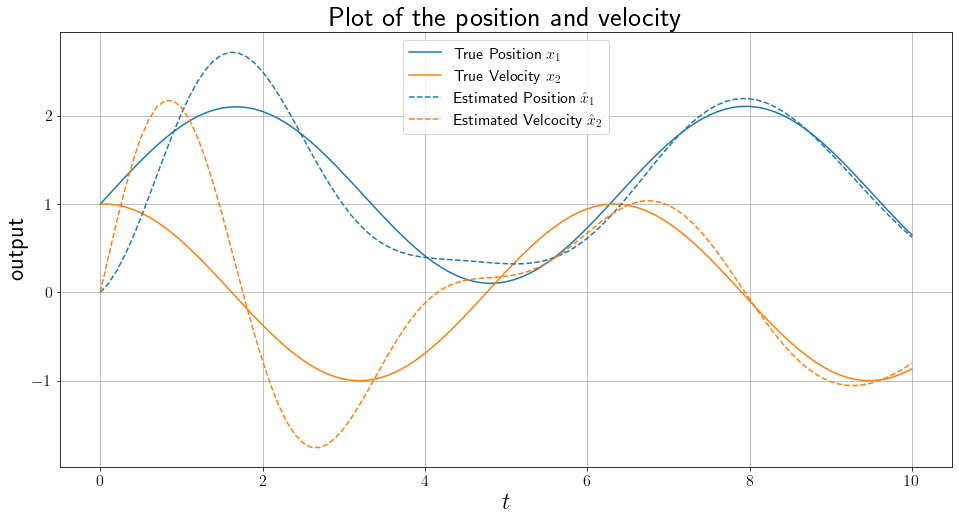

In [60]:
plt.figure(figsize=(16, 8))

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Plot the actual trajectories for the position and velocity
plt.plot(tV,x.reshape(numSteps,2))
plt.gca().set_prop_cycle(None) 

plt.plot(tV,xHat.reshape(numSteps,2),'--')

plt.legend([r'True Position $x_1$',r'True Velocity $x_2$', r'Estimated Position $\hat{x}_1$',r'Estimated Velcocity $\hat{x}_2$',r'Finite Difference Position',r'Finite difference velocity'],fontsize=16)
# The following line restarts the color cycles so that the actual and desired trajectories have the same colors
plt.gca().set_prop_cycle(None) 


plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the position and velocity',fontsize=28)
plt.grid()




## The Code for the Observable Example

### Preliminaries and Matrix Definitions for the Unobservable Problem

In the section below, we define attempt to estimate the full state $\hat{\vec{x}}$ given the following system and measurement: 
\begin{align*}
\dot{x} &= \underbrace{\begin{bmatrix}0 & 1\\0 & 0\end{bmatrix}}_{A}\vec{x} + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{B}u, \qquad \textsf{where } u(t) = -\sin(t)\\ \\
\vec{y} &= \underbrace{\begin{bmatrix} 1 & 0\end{bmatrix}}_{C}\vec{x}
\end{align*}

In the following block, we redefine the matrix $C$ and check the observability condition again

In [61]:
C = np.array([[1,0]])
O = ctrl.obsv(A,C)
rank = np.linalg.matrix_rank(O)

if rank==A.shape[0]:
    print('For the observability matrix O, the rank is '+str(rank)+'. The system is fully OBSERVABLE')
else:
    print('For the observability matrix O, the rank is '+str(rank)+'. The system is UNOBSERVABLE')

For the observability matrix O, the rank is 2. The system is fully OBSERVABLE


Now that we know the system is not observable, let's see what can be done.  We will define the matrices $F$, $G$ and $H$ as described above.  With 
$$H = \begin{bmatrix}8\\4\end{bmatrix}$$
the eigenvalues of $F = A - H C$ have negative real part.  


In [62]:


# Define the matrices F, G, and H and check that the eigenvalues of F = A - HC have negative real part
G = B
H = np.array([[8],[4]])  
F = A - H@C
eVals = np.linalg.eigvals(F);

if np.max(eVals.real)<0:
    print('\tSUCCESS!\n\t The eigenvalues of A - HC have negative real part and are given by: \n \t [lambda_1   lambda_2] = ' + str(eVals))
else:
    print('\tWARNING!\n\t At least one eigenvalue of A - HC is greater than or equal to zero.  The eigenvalues are given by: \n \t [lambda_1   lambda_2] = ' + str(eVals))

	SUCCESS!
	 The eigenvalues of A - HC have negative real part and are given by: 
 	 [lambda_1   lambda_2] = [-7.46410162 -0.53589838]


Now, let's compute the observations

In [63]:
# Set up the parameters for model.   
t0 = 0;
tf = 10;
numSteps = 101
tV = np.linspace(t0,tf,numSteps)
dt = tV[1]-tV[0]
x0 = np.array([[1],[1]])


# Initialize the true state vector
x = np.zeros((numSteps,2,1)); 
x[0,:,:] = x0

# Initialize the estimated state via the observer (xHat) and via finite-differences (xEst)
xHat = np.zeros((numSteps,2,1))
xEst = np.zeros((numSteps,2,1))


# Simulate the system and build the estimates
for j in range(0,numSteps-1):
    # Simulating the True System
    t = tV[j];
    x[j+1,:,:] = x[j,:,:] + dt*(A@x[j,:,:] + B@u(t))

    # Get the observation
    y = C@x[j,:,:]

    # Build the estimation of xHat
    xHat[j+1,:,:] = xHat[j,:,:] + dt*(F@xHat[j,:,:] + G@u(t) + H@y)

    # Using finite differences to estimate the velocity (just for fun)
    xEst[j+1,:,:] = xHat[j+1,:,:]; xEst[j+1,1,:] = (xHat[j+1,0,:]-xHat[j,0,:])/dt

### Plotting the output

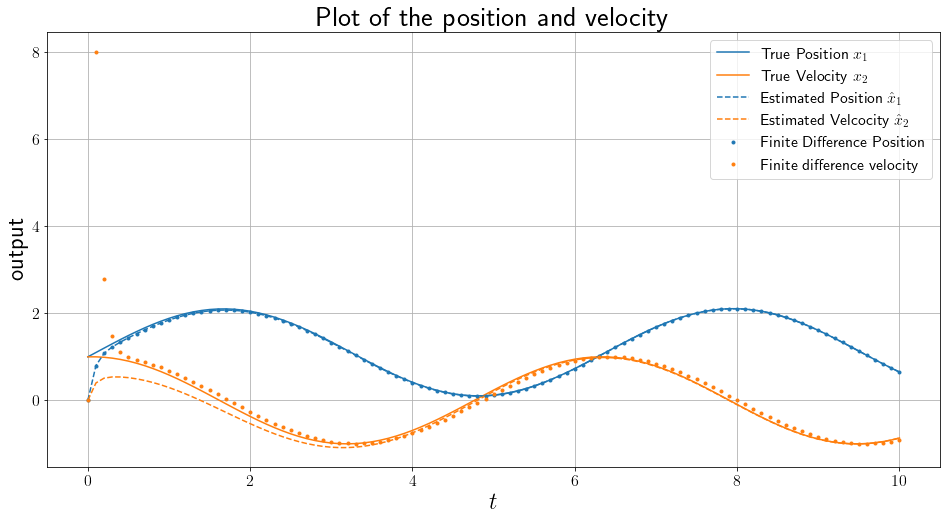

In [64]:
plt.figure(figsize=(16, 8))

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Plot the actual trajectories for the position and velocity
plt.plot(tV,x.reshape(numSteps,2))
plt.gca().set_prop_cycle(None) 

plt.plot(tV,xHat.reshape(numSteps,2),'--')
plt.gca().set_prop_cycle(None) 

plt.plot(tV,xEst.reshape(numSteps,2),'.')

plt.legend([r'True Position $x_1$',r'True Velocity $x_2$', r'Estimated Position $\hat{x}_1$',r'Estimated Velcocity $\hat{x}_2$',r'Finite Difference Position',r'Finite difference velocity'],fontsize=16)
# The following line restarts the color cycles so that the actual and desired trajectories have the same colors
plt.gca().set_prop_cycle(None) 


plt.xlabel(r'$t$', fontsize=24)
plt.ylabel(r'output', fontsize=24)
plt.title(r'Plot of the position and velocity',fontsize=28)
plt.grid()




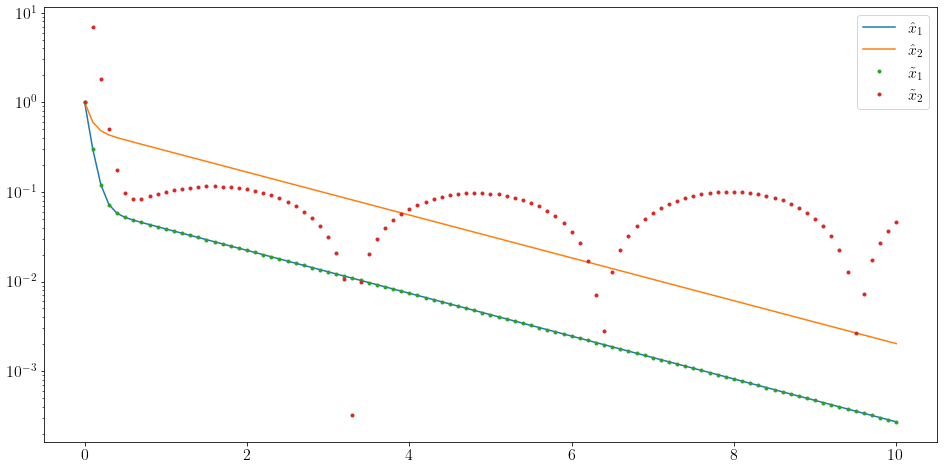

In [65]:
plt.figure(figsize=(16, 8))

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Plot the actual trajectories for the position and velocity
plt.semilogy(tV,np.abs(x.reshape(numSteps,2)-xHat.reshape(numSteps,2)))

plt.semilogy(tV,np.abs(x.reshape(numSteps,2)-xEst.reshape(numSteps,2)),'.')
plt.legend([r'$\hat{x}_1$',r'$\hat{x}_2$',r'$\tilde{x}_1$',r'$\tilde{x}_2$'],fontsize=16)
plt.show()